<a href="https://colab.research.google.com/github/0xrocky/superutils-script/blob/main/support_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import re


def save_chart_as_png(filename):
    """
    Save the current matplotlib chart as a PDF file.

    Parameters:
    filename (str): The name of the file to save the chart.
    """
    plt.savefig(filename, format='png', dpi=900)

def generate_metrics_charts(file_path):
    """
    Generate line charts for each quarter and a pie chart for the number of opened tickets per quarter.

    This function reads data from an Excel file, processes it, and generates the following charts:
    - Line charts for each quarter showing the trend of opened tickets and backlog.
    - A pie chart showing the distribution of opened tickets across quarters.
    - A combined line chart for the average monthly trends of backlog, opened, and closed tickets from Oct 2023 to Nov 2024.
    - Calculates and prints the average values for backlog, opened, and closed tickets for each quarter.

    Parameters:
    file_path (str): The path to the Excel file containing the data.
    """
    # Load the Excel file with multiple sheets
    xls = pd.ExcelFile(file_path)
    chart_filenames = []
    all_data = []

    # Iterate through each sheet that matches the pattern 'Metrics_yyyy_Qx'
    pattern = re.compile(r"Metrics_\d{4}_Q[1-4]")
    for sheet_name in xls.sheet_names:
        if pattern.match(sheet_name):
            # Load the sheet into a DataFrame
            df = pd.read_excel(xls, sheet_name=sheet_name)

            # Parse the date column to datetime format
            df['Date'] = pd.to_datetime(df['Date'])

            # Rename columns for easier reference
            df.rename(columns={
                'Date': 'date',
                'RITM Backlog': 'backlog',
                'RITM Opened': 'opened',
                'RITM Closed': 'closed',
                'RITM Fulfilled': 'fulfilled',
                'RITM Rejected': 'rejected',
                'INV Opened': 'inv_opened',
                'INV Closed': 'inv_closed'
            }, inplace=True)

            # Add a 'quarter' column to indicate which quarter each date belongs to
            df['quarter'] = df['date'].dt.to_period('Q')

            # Ensure 'quarter' column was created successfully
            if 'quarter' not in df.columns or df['quarter'].isnull().all():
                raise KeyError("*** The 'quarter' column does not exist or contains only null values. ***")

            # Filter out the last row (which represents the sum)
            filtered_df = df.dropna(subset=['date'])

            # Collect data for the pie chart across all sheets
            all_data.append(filtered_df)

            # Define quarters and their colors
            quarters = ['2023Q4', '2024Q1', '2024Q2', '2024Q3', '2024Q4']
            colors = {
                '2023Q4': '#46bd84',  # Light green
                '2024Q1': '#76ADEA',   # Light blue
                '2024Q2': '#FF2600',   # Bright red
                '2024Q3': '#FFB330',   # Orange
                '2024Q4': '#929292'    # Dark grey for ongoing
            }

            # Generate line charts for each quarter
            for quarter in quarters:
                quarter_df = filtered_df[filtered_df['quarter'] == quarter]

                # Filter NaN values in the data to avoid errors
                quarter_df = quarter_df.dropna(subset=['opened', 'backlog'])

                # Calculate and print sum and daily average for backlog, opened, and closed for the quarter
                if not quarter_df.empty:
                    backlog_sum = quarter_df['backlog'].sum()
                    opened_sum = quarter_df['opened'].sum()
                    closed_sum = quarter_df['closed'].sum()
                    backlog_avg = quarter_df['backlog'].mean()
                    opened_avg = quarter_df['opened'].mean()
                    closed_avg = quarter_df['closed'].mean()
                    print(f"*** Quarter {quarter} ({sheet_name}): ***")
                    print(f"***   Sum - Backlog: {backlog_sum}, Opened: {opened_sum}, Closed: {closed_sum} ***")
                    print(f"***   Daily Average - Backlog: {backlog_avg:.1f}, Opened: {opened_avg:.1f}, Closed: {closed_avg:.1f} ***")

                # Check if the DataFrame is not empty before plotting
                if not quarter_df.empty:
                    plt.figure(figsize=(12, 8))

                    # Plot opened tickets with a specific color
                    opened_color = colors[quarter]
                    backlog_color = opened_color  # Same color for backlog, but lighter shade for better visualization

                    plt.plot(quarter_df['date'], quarter_df['opened'], label='Opened', color=opened_color, marker='o', markersize=8,
                             markerfacecolor=opened_color, markeredgewidth=1.5, markeredgecolor='black', linewidth=2)

                    # Plot backlog with a lighter version of the opened tickets color
                    plt.plot(quarter_df['date'], quarter_df['backlog'], label='Backlog', color=backlog_color, linestyle='-', linewidth=2, alpha=0.3)

                    # Fit a linear trend line only if there are enough data points
                    if len(quarter_df) > 1:
                        x_values = np.arange(len(quarter_df))
                        y_values = quarter_df['opened'].values
                        coefficients = np.polyfit(x_values, y_values, 1)
                        trend_line = np.poly1d(coefficients)
                        plt.plot(quarter_df['date'], trend_line(x_values), color='black', linestyle='--', linewidth=2, label='Opening Trend')

                    # Set labels, title, and formatting for the chart
                    plt.xlabel('Date', fontsize=14, fontweight='bold')
                    plt.ylabel('Tickets', fontsize=14, fontweight='bold')
                    plt.title(f'Opened, Backlog and Trend - {quarter}', fontsize=18, fontweight='bold')

                    # Format the x-axis to show only month and day
                    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
                    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Show every seventh day for readability

                    # Set X-axis limits
                    plt.xlim(quarter_df['date'].min() - pd.Timedelta(days=1), quarter_df['date'].max() + pd.Timedelta(days=1))
                    plt.xticks(rotation=45, fontsize=12)

                    # Set Y-axis limits and tick frequency
                    min_y = int(min(quarter_df['opened'].min(), quarter_df['backlog'].min())) if not quarter_df.empty else 0
                    max_y = int(max(quarter_df['opened'].max(), quarter_df['backlog'].max())) + 4 if not quarter_df.empty else 4
                    plt.yticks(range(min_y, max_y, 4), fontsize=12)

                    # Add grid for better readability
                    plt.grid(visible=True, linestyle='--', linewidth=0.5)

                    # Add an annotation for the peak value, if it exists
                    if not quarter_df['opened'].empty:
                        max_opened_date = quarter_df.loc[quarter_df['opened'].idxmax()]['date']
                        max_opened_value = quarter_df['opened'].max()
                        plt.annotate(f'Peak: {max_opened_value}', xy=(max_opened_date, max_opened_value), xytext=(max_opened_date, min(max_opened_value + 5, max_y - 2)),
                                     arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12, fontweight='bold')

                    # Add legend
                    plt.legend(['Opened', 'Backlog', 'Opening Trend'], fontsize=12, loc='upper left')

                    # Set background color
                    plt.gca().patch.set_facecolor('#f5f5f5')

                    plt.tight_layout()
                    save_chart_as_png(f"line_chart_{sheet_name}_{quarter}.png")
                    plt.show()
                    plt.close()

                    # Append the filename to the list of generated charts
                    chart_filenames.append(f"line_chart_{sheet_name}_{quarter}.png")
                else:
                    print(f"*** No valid data for the chart of quarter {quarter} ({sheet_name}). ***")

    # Concatenate all data for generating the pie chart
    combined_df = pd.concat(all_data)

    # Calculate and print total sum and average for backlog, opened, and closed across all quarters
    total_backlog_sum = combined_df['backlog'].sum()
    total_opened_sum = combined_df['opened'].sum()
    total_closed_sum = combined_df['closed'].sum()
    total_backlog_avg = combined_df['backlog'].mean()
    total_opened_avg = combined_df['opened'].mean()
    total_closed_avg = combined_df['closed'].mean()
    print("*** Total for all quarters: ***")
    print(f"***   Sum - Backlog: {total_backlog_sum}, Opened: {total_opened_sum}, Closed: {total_closed_sum} ***")
    print(f"***   Average - Backlog: {total_backlog_avg:.1f}, Opened: {total_opened_avg:.1f}, Closed: {total_closed_avg:.1f} ***")

    # Generate and save the pie chart for "Opened Tickets per Quarter"
    opened_per_quarter = combined_df.groupby('quarter')['opened'].sum().reindex(quarters, fill_value=0)

    # Debugging: Print the opened_per_quarter to verify values
    print("*** Opened tickets per quarter: ***")
    print(opened_per_quarter)

    # Ensure that no quarter is missing by forcing very small values if zero
    opened_per_quarter = opened_per_quarter.apply(lambda x: x if x > 0 else 0.01)

    # Check if there are any valid data points to plot
    if opened_per_quarter.sum() > 0:
        colors_pie = [colors[quarter] for quarter in opened_per_quarter.index]
        explode_values = [0.05] * len(opened_per_quarter)  # Slightly separate each quarter

        plt.figure(figsize=(12, 12))
        plt.pie(opened_per_quarter, labels=opened_per_quarter.index, colors=colors_pie, autopct='%1.1f%%', startangle=90,
                explode=explode_values, wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, textprops={'fontsize': 14})
        plt.title(f'Opened Tickets per Quarter', fontsize=20, fontweight='bold')
        plt.legend(opened_per_quarter.index, title="Quarters", loc="upper left", fontsize=12, title_fontsize=14)
        plt.tight_layout()
        save_chart_as_png(f"pie_chart_opened_tickets_per_quarter_all_sheets.png")
        plt.show()
        plt.close()

        # Append the filename to the list of generated charts
        chart_filenames.append(f"pie_chart_opened_tickets_per_quarter_all_sheets.png")
    else:
        print(f"*** No valid data for pie chart of opened tickets across all sheets. ***")

    # Generate a combined line chart for average monthly trends from Oct 2023 to Nov 2024
    combined_df['year'] = combined_df['date'].dt.year
    combined_df['month'] = combined_df['date'].dt.month

    monthly_means = combined_df.groupby(['year', 'month']).agg({
        'backlog': 'mean',
        'opened': 'mean',
        'closed': 'mean'
    }).reset_index()

    monthly_means['date'] = pd.to_datetime(monthly_means[['year', 'month']].assign(day=1))

    plt.figure(figsize=(16, 10))
    plt.plot(monthly_means['date'], monthly_means['backlog'], label='Backlog', color='#76ADEA', marker='o', markersize=6,
             markerfacecolor='#76ADEA', markeredgewidth=1.5, markeredgecolor='black', linewidth=2)
    plt.plot(monthly_means['date'], monthly_means['opened'], label='Opened', color='#FF2600', marker='o', markersize=6,
             markerfacecolor='#FF2600', markeredgewidth=1.5, markeredgecolor='black', linewidth=2)
    plt.plot(monthly_means['date'], monthly_means['closed'], label='Closed', color='#46bd84', marker='o', markersize=6,
             markerfacecolor='#46bd84', markeredgewidth=1.5, markeredgecolor='black', linewidth=2)

    # Find the overall peak among backlog, opened, and closed
    max_value = monthly_means[['backlog', 'opened', 'closed']].max().max()
    max_metric = monthly_means[['backlog', 'opened', 'closed']].idxmax().max()
    max_date = monthly_means.iloc[max_metric]['date']
    plt.annotate(f'Peak: {max_value:.1f}', xy=(max_date, max_value), xytext=(max_date, min(max_value + 1, max_y - 2)),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12, fontweight='bold')

    # Labels and title
    plt.xlabel('Month', fontsize=14, fontweight='bold')
    plt.ylabel('Average Tickets', fontsize=14, fontweight='bold')
    plt.title('Average Monthly Trends', fontsize=18, fontweight='bold')

    # Set y-axis with a frequency of 4 for readability
    min_y = 0
    max_y = int(monthly_means[['backlog', 'opened', 'closed']].max().max()) + 4
    plt.yticks(range(min_y, max_y, 4), fontsize=12)

    # Add grid for better readability
    plt.grid(visible=True, linestyle='--', linewidth=0.5)

    # Add legend with updated labels
    plt.legend(fontsize=12, loc='upper left')

    plt.tight_layout()
    save_chart_as_png("combined_average_monthly_trends_2023_2024.png")
    plt.show()
    plt.close()
    chart_filenames.append("combined_average_monthly_trends_2023_2024.png")

    return chart_filenames

In [9]:
def generate_tags_charts(file_path):
    """
    Generates pie charts based on different tag distributions in the given Excel file.

    The function reads three sheets from the Excel file:
    1. 'Tags_Topic': Generates a pie chart representing tag distribution by topic.
    2. 'Tags_Technology': Generates a pie chart representing tag distribution by technology.
    3. 'Tags_User' (optional): If the sheet is present, generates a pie chart representing tag distribution by user.

    Each pie chart is displayed with enhanced formatting, including separated slices, borders, and detailed legends.

    Parameters:
    file_path (str): The path to the Excel file containing the data.
    """

    # Load the Excel file
    xls = pd.ExcelFile(file_path)

    # Load each sheet into a DataFrame, ignoring the 'Description' column if present
    df_topic = pd.read_excel(xls, sheet_name='Tags_Topic').drop(columns=['Description'], errors='ignore')
    df_technology = pd.read_excel(xls, sheet_name='Tags_Technology').drop(columns=['Description'], errors='ignore')

    # Clean the data by removing any non-numeric values in the 'Number' column
    df_topic_clean = df_topic[pd.to_numeric(df_topic['Number'], errors='coerce').notnull()]
    df_technology_clean = df_technology[pd.to_numeric(df_technology['Number'], errors='coerce').notnull()]

    # Remove the prefix "support_" from the 'Tag' column for both DataFrames
    df_topic_clean['Tag'] = df_topic_clean['Tag'].str.replace('^support_', '', regex=True)
    df_technology_clean['Tag'] = df_technology_clean['Tag'].str.replace('^support_', '', regex=True)

    # Plotting pie chart for 'Tag Distribution by Topic' with separated slices, borders, and updated legend format
    plt.figure(figsize=(10, 5))
    colors_topic = plt.cm.tab20.colors  # Use tab20 colormap for more colors
    wedges, texts = plt.pie(df_topic_clean['Number'], labels=None, startangle=140, colors=colors_topic,
                            wedgeprops={'edgecolor': 'black', 'linewidth': 1}, explode=[0.05] * len(df_topic_clean))
    plt.title('Tag Distribution by Topic', fontsize=16)

    # Adding updated percentages to legend
    legend_labels = [f"{tag}: {percent:.1f}% ({number})" for tag, number, percent in
                     zip(df_topic_clean['Tag'], df_topic_clean['Number'],
                         100 * df_topic_clean['Number'] / df_topic_clean['Number'].sum())]
    plt.legend(wedges, legend_labels, title='Tags', bbox_to_anchor=(1.05, 1), fontsize='large', fancybox=True, frameon=True)
    plt.tight_layout()
    plt.show()

    # Plotting pie chart for 'Tag Distribution by Technology' with increased figure size and updated legend format
    plt.figure(figsize=(12, 6))  # Increased figure size for better readability
    colors_technology = plt.cm.tab20.colors  # Use tab20 colormap for more colors
    wedges, texts = plt.pie(df_technology_clean['Number'], labels=None, startangle=140, colors=colors_technology,
                            wedgeprops={'edgecolor': 'black', 'linewidth': 1}, explode=[0.05] * len(df_technology_clean))
    plt.title('Tag Distribution by Technology', fontsize=16)

    # Adding updated percentages to legend
    legend_labels = [f"{tag}: {percent:.1f}% ({number})" for tag, number, percent in
                     zip(df_technology_clean['Tag'], df_technology_clean['Number'],
                         100 * df_technology_clean['Number'] / df_technology_clean['Number'].sum())]
    plt.legend(wedges, legend_labels, title='Tags', bbox_to_anchor=(1.05, 1), fontsize='large', fancybox=True, frameon=True)
    plt.tight_layout()
    plt.show()

    # Optional: Plotting pie chart for 'Tag Distribution by User' if the sheet exists
    if 'Tag Distribution by User' in xls.sheet_names:
        df_user = pd.read_excel(xls, sheet_name='Tags_User').drop(columns=['Description'], errors='ignore')
        df_user_clean = df_user[pd.to_numeric(df_user['Number'], errors='coerce').notnull()]
        df_user_clean['Tag'] = df_user_clean['Tag'].str.replace('^support_', '', regex=True)

        # Plotting pie chart for 'Tag Distribution by User'
        plt.figure(figsize=(10, 5))
        colors_user = plt.cm.tab20.colors  # Use tab20 colormap for more colors
        wedges, texts = plt.pie(df_user_clean['Number'], labels=None, startangle=140, colors=colors_user,
                                wedgeprops={'edgecolor': 'black', 'linewidth': 1}, explode=[0.05] * len(df_user_clean))
        plt.title('Tag Distribution by User', fontsize=16)

        # Adding updated percentages to legend
        legend_labels = [f"{tag}: {percent:.1f}% ({number})" for tag, number, percent in
                         zip(df_user_clean['Tag'], df_user_clean['Number'],
                             100 * df_user_clean['Number'] / df_user_clean['Number'].sum())]
        plt.legend(wedges, legend_labels, title='Tags', bbox_to_anchor=(1.05, 1), fontsize='large', fancybox=True, frameon=True)
        plt.tight_layout()
        plt.show()

# Example usage:
# generate_tags_charts('path/to/your/excel/file.xlsx')

*** Quarter 2023Q4 (Metrics_2023_Q4): ***
***   Sum - Backlog: 232, Opened: 157, Closed: 163 ***
***   Daily Average - Backlog: 7.7, Opened: 5.2, Closed: 5.4 ***


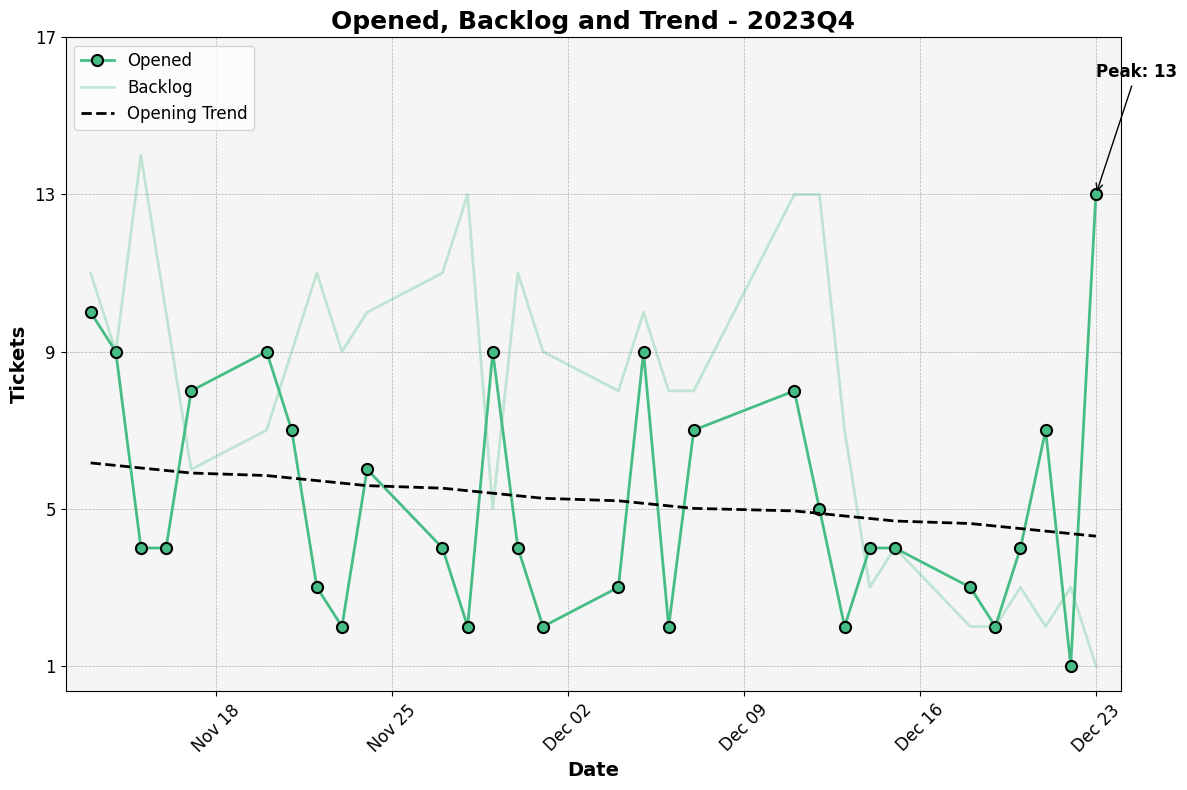

*** No valid data for the chart of quarter 2024Q1 (Metrics_2023_Q4). ***
*** No valid data for the chart of quarter 2024Q2 (Metrics_2023_Q4). ***
*** No valid data for the chart of quarter 2024Q3 (Metrics_2023_Q4). ***
*** No valid data for the chart of quarter 2024Q4 (Metrics_2023_Q4). ***
*** No valid data for the chart of quarter 2023Q4 (Metrics_2024_Q1). ***
*** Quarter 2024Q1 (Metrics_2024_Q1): ***
***   Sum - Backlog: 250, Opened: 299, Closed: 291 ***
***   Daily Average - Backlog: 4.2, Opened: 5.0, Closed: 4.8 ***


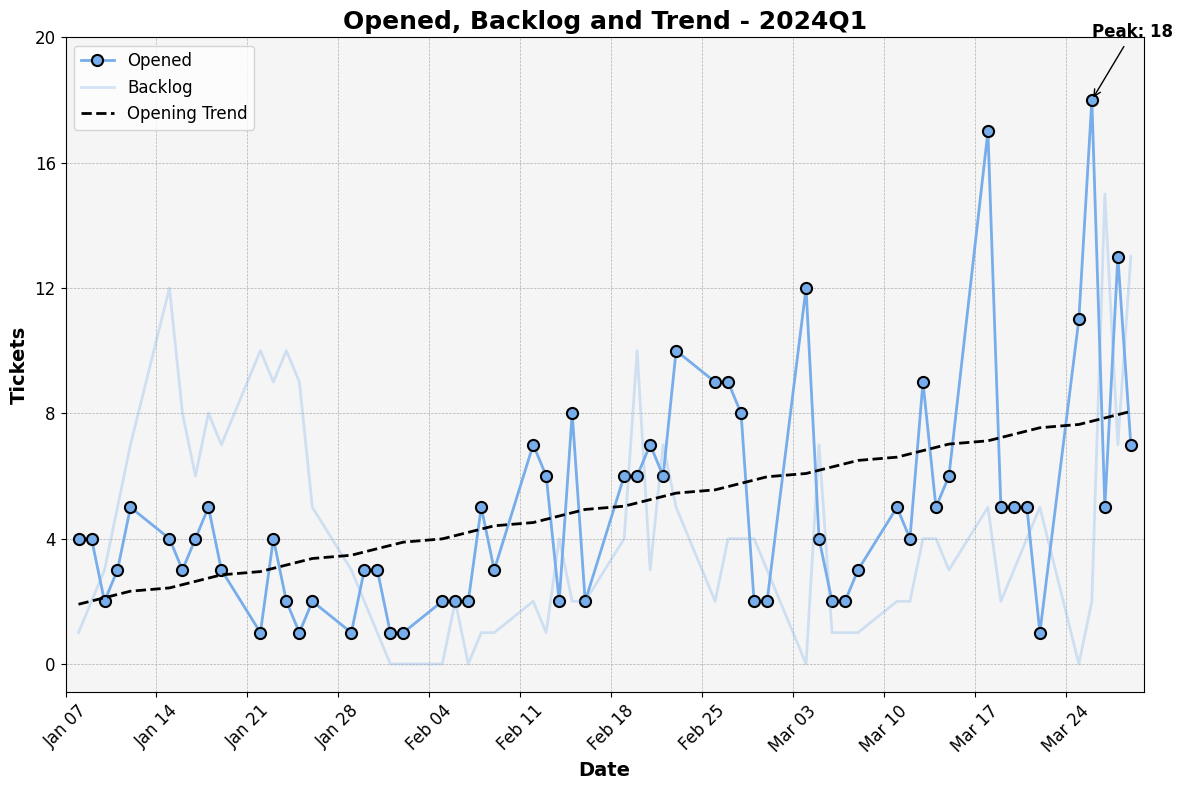

*** No valid data for the chart of quarter 2024Q2 (Metrics_2024_Q1). ***
*** No valid data for the chart of quarter 2024Q3 (Metrics_2024_Q1). ***
*** No valid data for the chart of quarter 2024Q4 (Metrics_2024_Q1). ***
*** No valid data for the chart of quarter 2023Q4 (Metrics_2024_Q2). ***
*** No valid data for the chart of quarter 2024Q1 (Metrics_2024_Q2). ***
*** Quarter 2024Q2 (Metrics_2024_Q2): ***
***   Sum - Backlog: 419, Opened: 478, Closed: 479 ***
***   Daily Average - Backlog: 6.8, Opened: 7.7, Closed: 7.7 ***


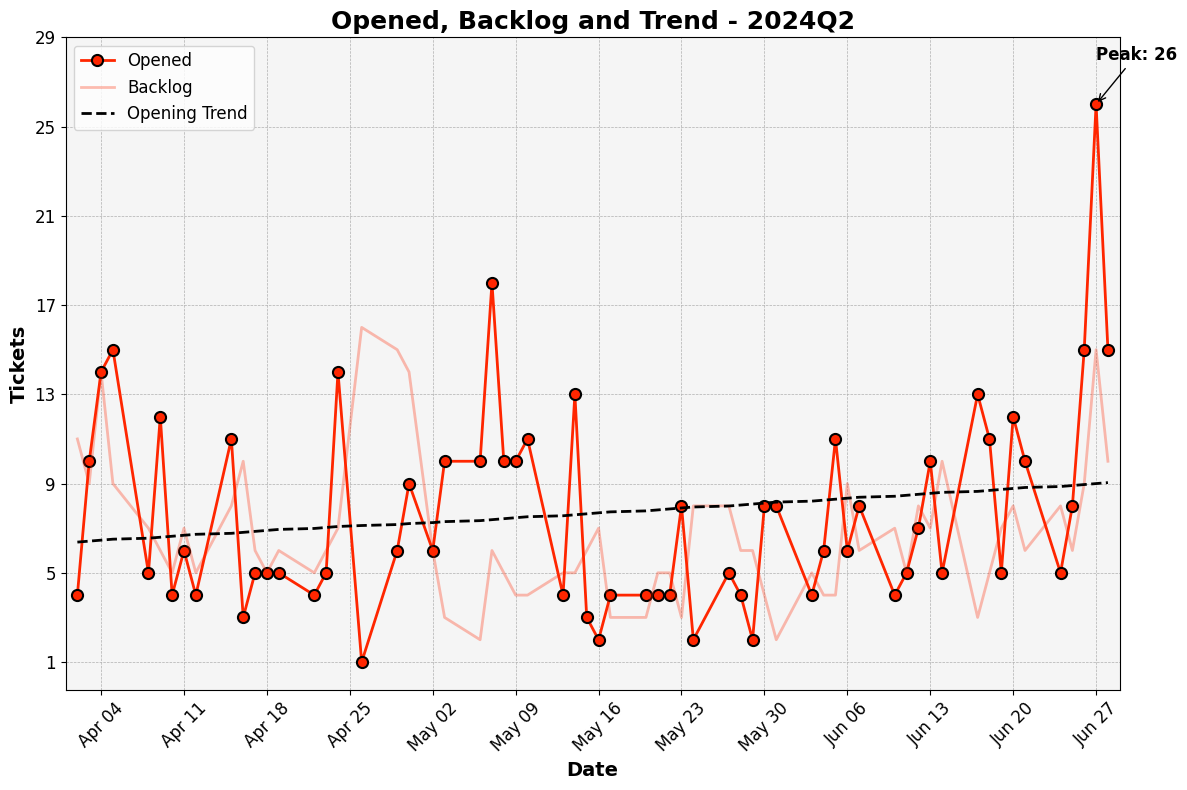

*** No valid data for the chart of quarter 2024Q3 (Metrics_2024_Q2). ***
*** No valid data for the chart of quarter 2024Q4 (Metrics_2024_Q2). ***
*** No valid data for the chart of quarter 2023Q4 (Metrics_2024_Q3). ***
*** No valid data for the chart of quarter 2024Q1 (Metrics_2024_Q3). ***
*** No valid data for the chart of quarter 2024Q2 (Metrics_2024_Q3). ***
*** Quarter 2024Q3 (Metrics_2024_Q3): ***
***   Sum - Backlog: 597, Opened: 392, Closed: 406 ***
***   Daily Average - Backlog: 9.2, Opened: 6.0, Closed: 6.2 ***


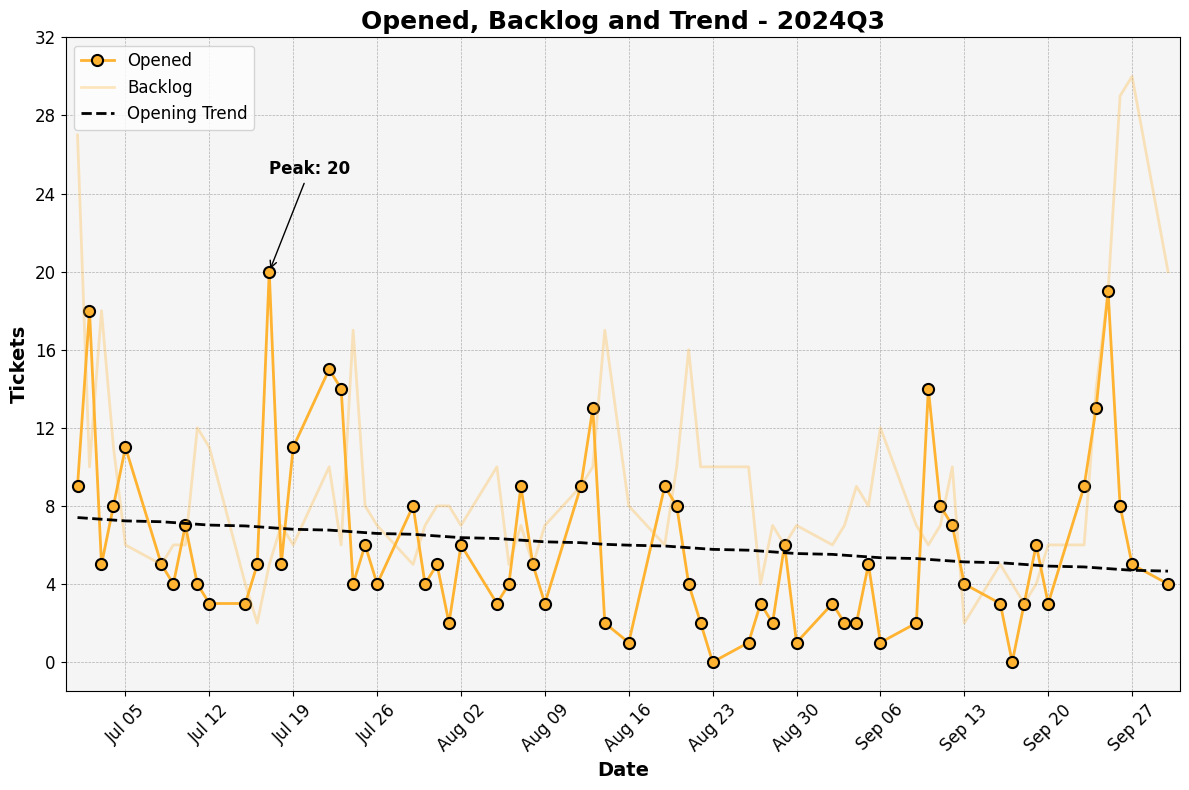

*** No valid data for the chart of quarter 2024Q4 (Metrics_2024_Q3). ***
*** No valid data for the chart of quarter 2023Q4 (Metrics_2024_Q4). ***
*** No valid data for the chart of quarter 2024Q1 (Metrics_2024_Q4). ***
*** No valid data for the chart of quarter 2024Q2 (Metrics_2024_Q4). ***
*** No valid data for the chart of quarter 2024Q3 (Metrics_2024_Q4). ***
*** Quarter 2024Q4 (Metrics_2024_Q4): ***
***   Sum - Backlog: 450, Opened: 202, Closed: 188 ***
***   Daily Average - Backlog: 19.6, Opened: 8.8, Closed: 8.2 ***


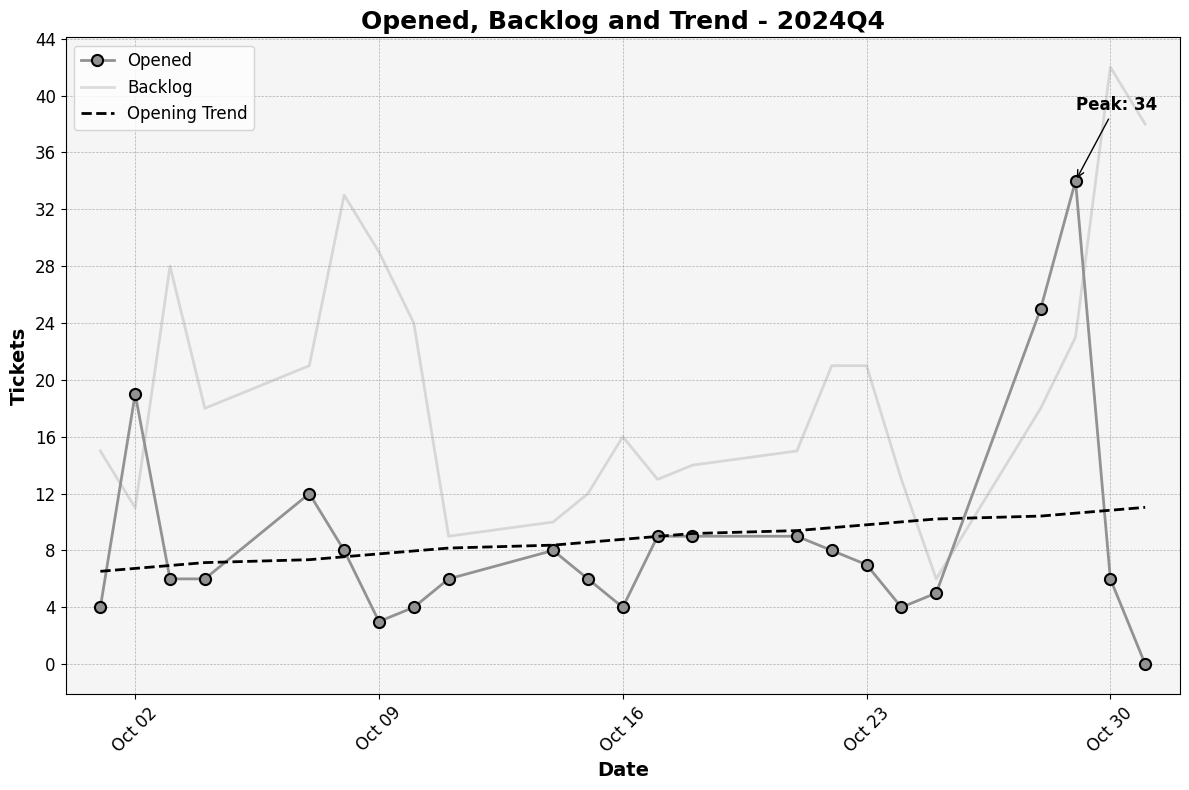

*** Total for all quarters: ***
***   Sum - Backlog: 1948, Opened: 1528, Closed: 1527 ***
***   Average - Backlog: 8.1, Opened: 6.4, Closed: 6.4 ***
*** Opened tickets per quarter: ***
quarter
2023Q4    157
2024Q1    299
2024Q2    478
2024Q3    392
2024Q4    202
Name: opened, dtype: int64


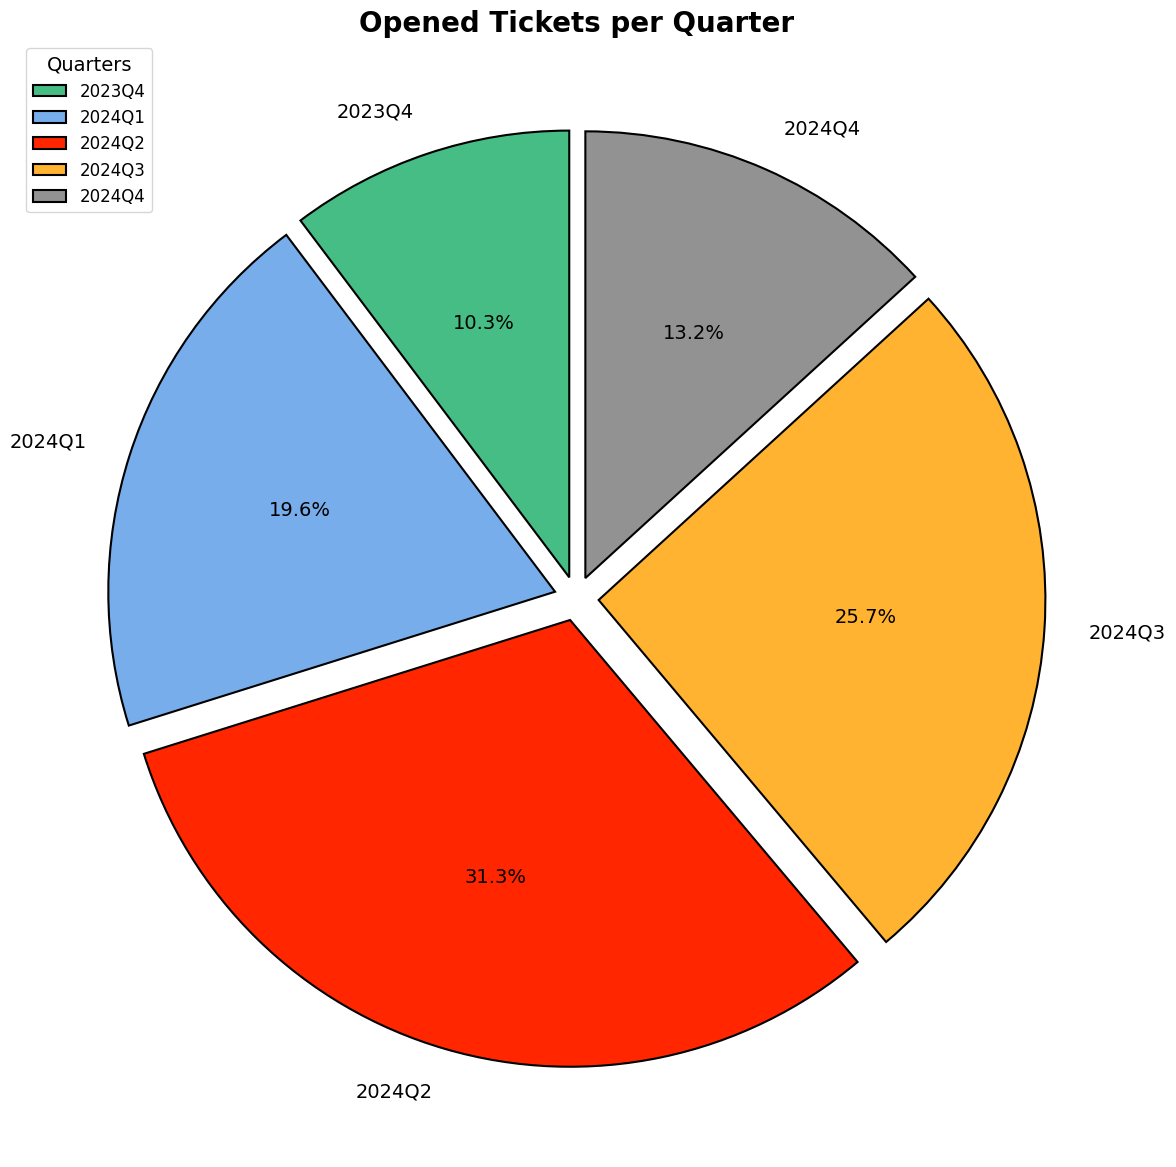

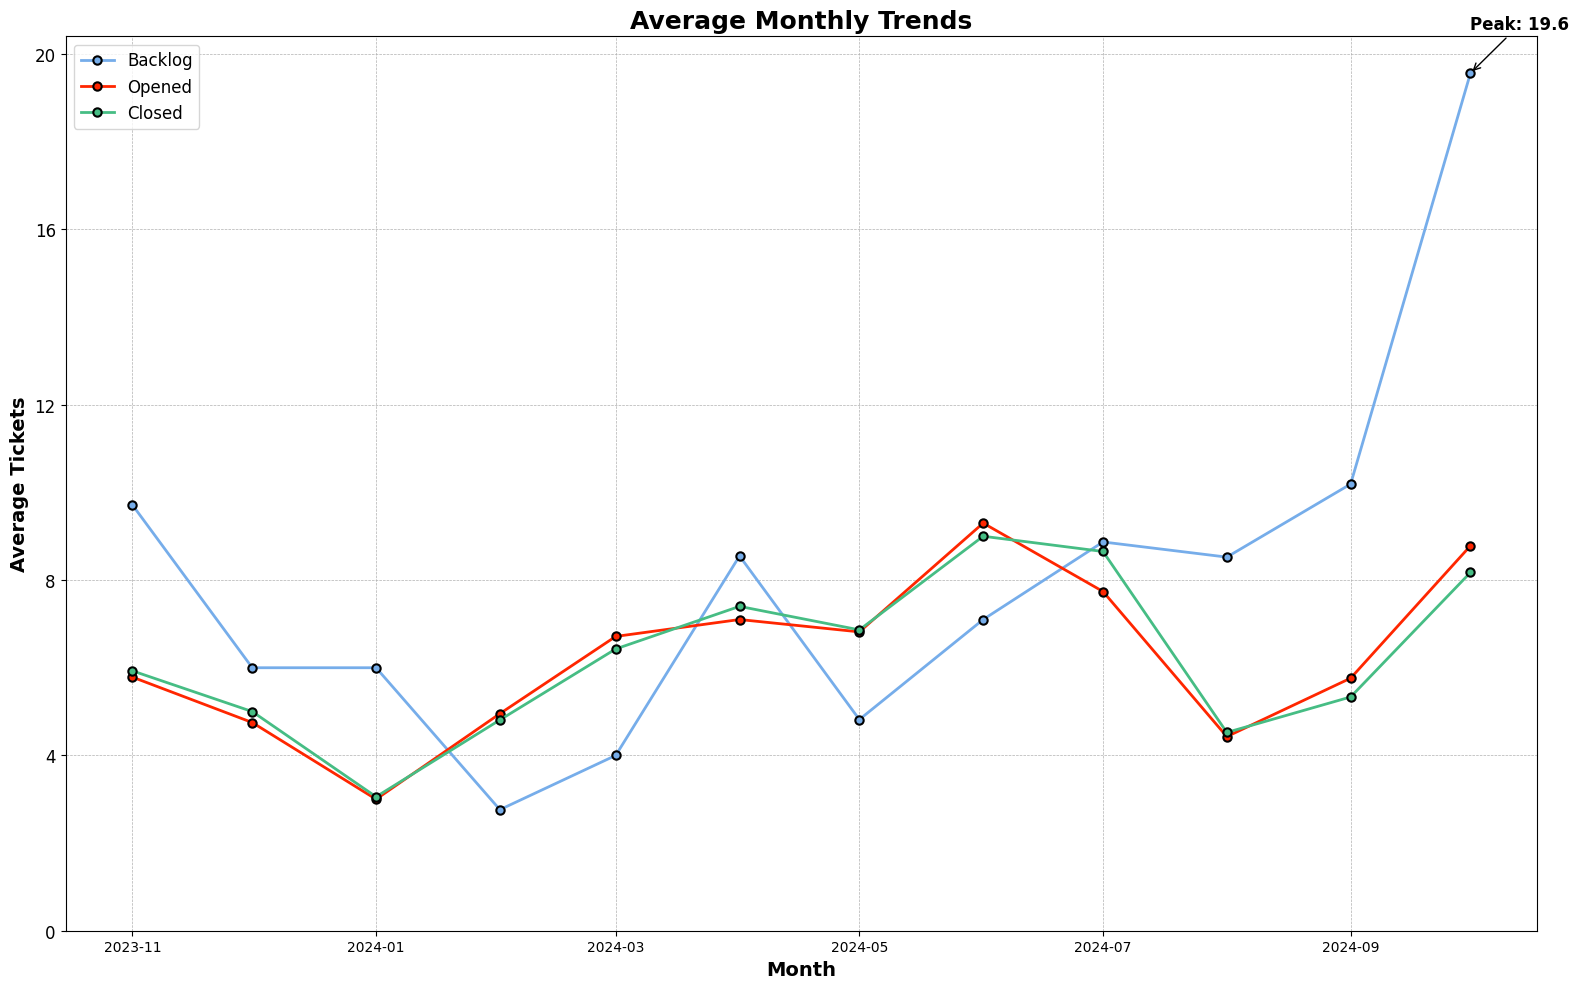

['line_chart_Metrics_2023_Q4_2023Q4.png',
 'line_chart_Metrics_2024_Q1_2024Q1.png',
 'line_chart_Metrics_2024_Q2_2024Q2.png',
 'line_chart_Metrics_2024_Q3_2024Q3.png',
 'line_chart_Metrics_2024_Q4_2024Q4.png',
 'pie_chart_opened_tickets_per_quarter_all_sheets.png',
 'combined_average_monthly_trends_2023_2024.png']

In [7]:
generate_metrics_charts('/content/support_metrics_30.10.24.xlsx')

<ipython-input-9-53b3a8bae7bf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_technology_clean['Tag'] = df_technology_clean['Tag'].str.replace('^support_', '', regex=True)


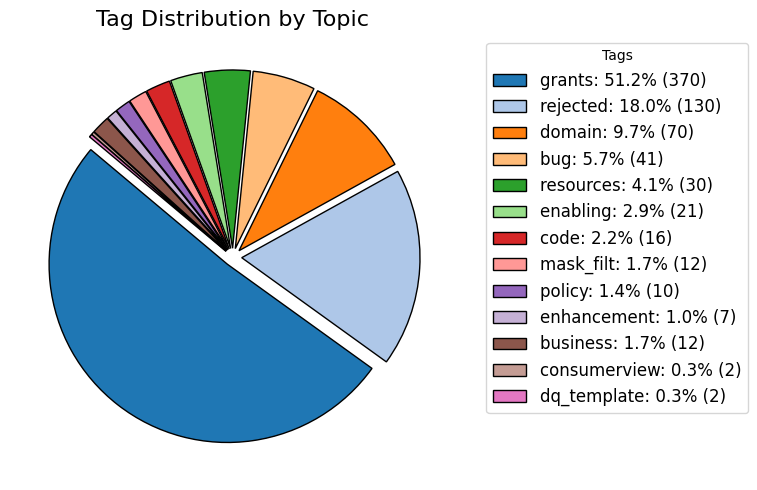

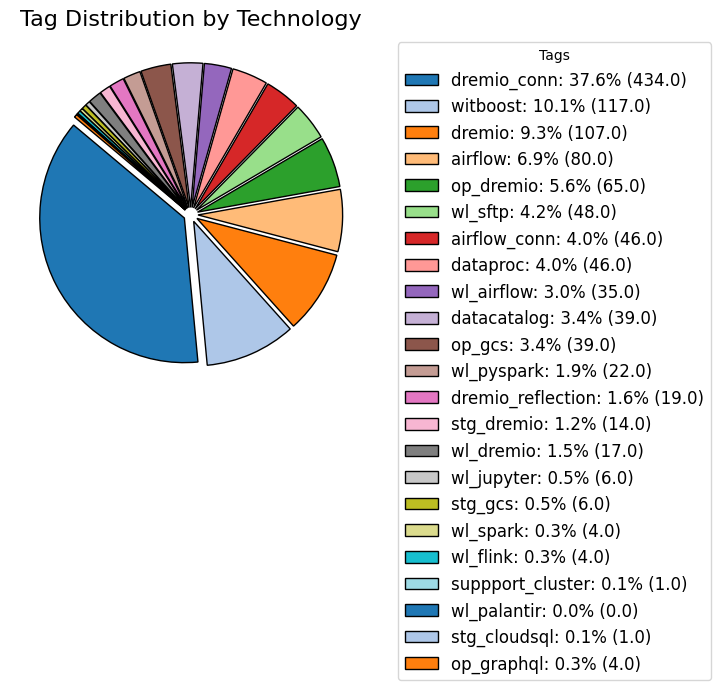

In [10]:
generate_tags_charts('/content/support_metrics_30.10.24.xlsx')